In [46]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix
import itertools

%matplotlib inline

Загружаем новости

In [47]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [48]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Получаем векторные представления новостей

In [49]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

morph = pymorphy2.MorphAnalyzer()

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
print(len(stopword_ru))

151
776


In [50]:
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())

    return text

In [51]:
cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

In [52]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 31 s


In [53]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 2min 55s


In [54]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [55]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Запускаем обучение

In [56]:
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)

In [57]:
temp_file = datapath("model.lda")
lda.save(temp_file)

lda = LdaModel.load(temp_file)

In [58]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.03724668),
 (5, 0.39115772),
 (6, 0.31586507),
 (16, 0.1895501),
 (17, 0.04838175)]

In [59]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: компания исследование банк год автор бизнес доход
topic_1: остров это способность всё выяснить человек очень
topic_2: год земля который время это день район
topic_3: журнал миссия выяснить завод сигнал экипаж воздух
topic_4: который мочь это сша американский взрыв всё
topic_5: поток европа это мочь северный товар дыра
topic_6: рак год небо годовой звезда хороший собирать
topic_7: высота метр секунда австралия ленинградский доклад сантиметр
topic_8: год это который свой мочь человек россия
topic_9: газ ребёнок космос препарат квартира статья катастрофа
topic_10: российский год россия это страна президент правительство
topic_11: обнаружить пилот метод район двигатель бой остановка
topic_12: который год россия nn это также санкция
topic_13: доллар вероятно таможенный калифорния визовый понятие зеландия
topic_14: пациент исследование место участок nn торговый рейтинг
topic_15: год млн рост составить ставка снижение цена
topic_16: фестиваль мероприятие nn пройти сайт программа узна

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [60]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [61]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013566,0.0,0.0,...,0.0,0.000000,0.103347,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,4896,0.0000,0.000000,0.000000,0.000000,0.623429,0.000000,0.000000,0.0,0.0,...,0.0,0.300925,0.000000,0.0,0.0,0.0,0.0,0.0,0.053632,0.0
2,4897,0.0000,0.000000,0.000000,0.037221,0.000000,0.391195,0.315893,0.0,0.0,...,0.0,0.189648,0.048244,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,4898,0.0000,0.094053,0.205166,0.000000,0.449743,0.000000,0.000000,0.0,0.0,...,0.0,0.241109,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,4899,0.6146,0.000000,0.000000,0.000000,0.000000,0.000000,0.103893,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


Векторные представления пользователей

In [62]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [63]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [64]:
user_articles_list = users['articles'].iloc[33]

In [65]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [66]:
get_user_embedding(user_articles_list)

array([0.02584651, 0.        , 0.0275831 , 0.        , 0.02805214,
       0.02007635, 0.02111385, 0.        , 0.26849102, 0.01651056,
       0.16863022, 0.00498433, 0.21432235, 0.        , 0.        ,
       0.01576106, 0.01207212, 0.        , 0.        , 0.        ,
       0.        , 0.00326658, 0.09463341, 0.0165563 , 0.04932132])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [67]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.007265,0.052407,0.027479,0.018088,0.005653,0.022973,0.002378,0.104431,...,0.013094,0.076854,0.033462,0.005368,0.0,0.0,0.020005,0.404990,0.000000,0.010399
1,u108690,0.000000,0.018159,0.098149,0.000000,0.028164,0.015756,0.001842,0.000000,0.189192,...,0.034075,0.003674,0.001777,0.010967,0.0,0.0,0.000000,0.356275,0.002021,0.019035
2,u108339,0.003412,0.005600,0.233095,0.005215,0.025918,0.013105,0.025626,0.000000,0.133007,...,0.000000,0.001716,0.002096,0.000000,0.0,0.0,0.004730,0.135881,0.008986,0.020475


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [68]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [69]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.007265,0.052407,0.027479,0.018088,0.005653,0.022973,0.002378,0.104431,...,0.076854,0.033462,0.005368,0.0,0.0,0.020005,0.404990,0.000000,0.010399,0
1,u108690,0.000000,0.018159,0.098149,0.000000,0.028164,0.015756,0.001842,0.000000,0.189192,...,0.003674,0.001777,0.010967,0.0,0.0,0.000000,0.356275,0.002021,0.019035,1
2,u108339,0.003412,0.005600,0.233095,0.005215,0.025918,0.013105,0.025626,0.000000,0.133007,...,0.001716,0.002096,0.000000,0.0,0.0,0.004730,0.135881,0.008986,0.020475,1


In [70]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [71]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [72]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16674982, 0.13480784, 0.47540515, 0.32103503, 0.01653307,
       0.02283325, 0.17431023, 0.0166754 , 0.02206424, 0.07529204])

Рассчитаем Precision, Recall, F_score

In [73]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.292877, F-Score=0.677, Precision=0.621, Recall=0.743


In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1644  111]
 [  64  181]]


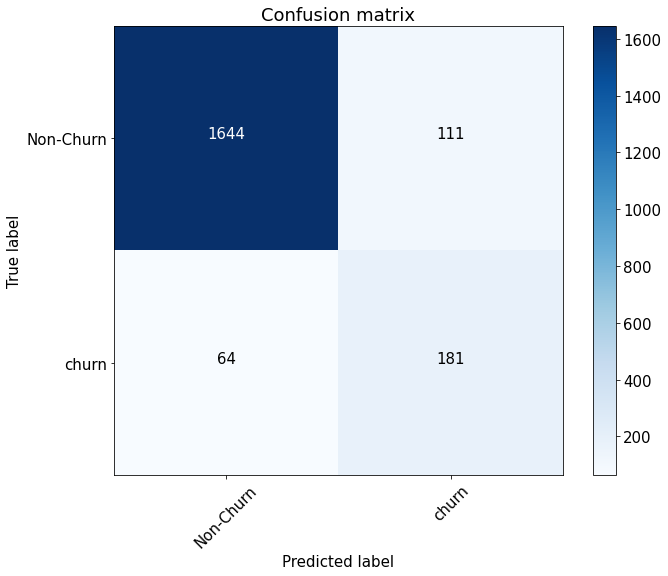

In [75]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [76]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9433153090295948

#### Выше приведен код и расчеты какие были на уроке. модифицируем метод get_user_embedding, чтобы он считался по медиане и повторим обучения и посмотрим на метрики

In [77]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [78]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.000000,0.000000,0.018636,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.095542,0.0,0.0,0.0,0.0,0.0,0.365097,0.0,0.000000
1,u108690,0.0,0.007336,0.077598,0.000000,0.000000,0.0,0.0,0.0,0.150434,...,0.007042,0.000000,0.0,0.0,0.0,0.0,0.0,0.306949,0.0,0.015258
2,u108339,0.0,0.000000,0.210225,0.000000,0.019557,0.0,0.0,0.0,0.112159,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.152773,0.0,0.020731


In [79]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.000000,0.000000,0.018636,0.000000,0.0,0.0,0.0,0.000000,...,0.095542,0.0,0.0,0.0,0.0,0.0,0.365097,0.0,0.000000,0
1,u108690,0.0,0.007336,0.077598,0.000000,0.000000,0.0,0.0,0.0,0.150434,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.306949,0.0,0.015258,1
2,u108339,0.0,0.000000,0.210225,0.000000,0.019557,0.0,0.0,0.0,0.112159,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.152773,0.0,0.020731,1


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [81]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [82]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1204272 , 0.03125435, 0.40979077, 0.28990052, 0.01966754,
       0.00542115, 0.13192829, 0.03512215, 0.03533489, 0.05791006])

In [83]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test, preds)
fscore_median = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix],
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold=0.486458, F-Score=0.677, Precision=0.831, Recall=0.400


In [84]:
roc_auc_median = roc_auc_score(y_test, preds)
roc_auc_median

0.9597557997557998

#### Теперь сделаем тоже самое, но вместо медианы будем использовать максимум

In [85]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [86]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.000000,0.032894,0.164193,0.089619,0.108531,0.033918,0.137838,0.014265,0.365816,...,0.078562,0.148177,0.117937,0.018474,0.0,0.0,0.120027,0.734691,0.000000,0.042880
1,u108690,0.000000,0.063088,0.229510,0.000000,0.107270,0.064535,0.011055,0.000000,0.412001,...,0.129313,0.022044,0.010663,0.065800,0.0,0.0,0.000000,0.741503,0.012129,0.050603
2,u108339,0.020472,0.018977,0.395813,0.031292,0.071029,0.047897,0.153753,0.000000,0.217805,...,0.000000,0.010299,0.012578,0.000000,0.0,0.0,0.028377,0.215227,0.040241,0.049742


In [87]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.000000,0.032894,0.164193,0.089619,0.108531,0.033918,0.137838,0.014265,0.365816,...,0.148177,0.117937,0.018474,0.0,0.0,0.120027,0.734691,0.000000,0.042880,0
1,u108690,0.000000,0.063088,0.229510,0.000000,0.107270,0.064535,0.011055,0.000000,0.412001,...,0.022044,0.010663,0.065800,0.0,0.0,0.000000,0.741503,0.012129,0.050603,1
2,u108339,0.020472,0.018977,0.395813,0.031292,0.071029,0.047897,0.153753,0.000000,0.217805,...,0.010299,0.012578,0.000000,0.0,0.0,0.028377,0.215227,0.040241,0.049742,1


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]],
                                                    X['churn'], random_state=0)

In [89]:
logreg = LogisticRegression()
#обучим
logreg.fit(X_train, y_train)

LogisticRegression()

In [90]:
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10213572, 0.01616569, 0.80773281, 0.14522035, 0.01485858,
       0.05773291, 0.07876976, 0.00572049, 0.00751676, 0.15961793])

In [91]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test, preds)
fscore_max = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix],
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold=0.072400, F-Score=0.677, Precision=0.293, Recall=0.947


In [92]:
roc_auc_max = roc_auc_score(y_test, preds)
roc_auc_max

0.9441107041107041

#### Теперь сравним все метрики, с средним, медианой и максимальной

In [94]:
print('Mean Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

print('Median Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix],
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

print('Max Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix],
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Mean Threshold=0.292877, F-Score=0.677, Precision=0.621, Recall=0.743
Median Threshold=0.486458, F-Score=0.677, Precision=0.831, Recall=0.400
Max Threshold=0.072400, F-Score=0.677, Precision=0.293, Recall=0.947


In [95]:
print('Mean roc auc: %f', roc_auc)
print('Median roc auc: %f', roc_auc_median)
print('Max roc auc: %f', roc_auc_max)

Mean roc auc: %f 0.9433153090295948
Median roc auc: %f 0.9597557997557998
Max roc auc: %f 0.9441107041107041


#### По метрикам видно что ф1 метрика везде одинаковая, по precision и recall более менее уравновешенная метрика получается в среднем, в медиане идет перевес в сторону precision а в максимуме в сторону recall

#### Если смотреть на мертику roc auc, то она особо не менялась